In [15]:
# sudoku solve opencv
import cv2
import numpy as np
import tensorflow as tf

In [2]:
# path of the image 
pathimage = "./sudoku2.jpg"
hgt = 450
wdt = 450

In [3]:
# preparing the image 
img = cv2.imread(pathimage)
img = cv2.resize(img,(hgt,wdt))
imgblank = np.zeros((hgt,wdt,3),np.uint8)

In [4]:
# pre processing the image
def preprocess(img):
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
    imgThreshold = cv2.adaptiveThreshold(imgBlur,255,1,1,11,2)
    return(imgThreshold)


In [5]:
# pre processing 
imgpre = preprocess(img)

In [6]:
# stack images example function 
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver


In [27]:
imgStack = stackImages(0.5,([img,imgpre,imgcontours,imgbigcontour],[imgWarpCol,imgblank,imgblank,imgblank]))
# showing the output 
cv2.imshow("Final Stack", imgStack)
cv2.waitKey(0)

-1

In [7]:
# finding contours
imgcontours = img.copy()
imgbigcontour = img.copy()
contours, hierarchy = cv2.findContours(imgpre,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
imgcontours=cv2.drawContours(imgcontours, contours, -1,(0,255,0),3)

In [8]:
# getting the biggest area and contour
def biggestcontour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area>50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02*peri, True)
            if area>max_area and len(approx)==4:
                biggest = approx
                max_area =  area
    return(biggest,max_area)

def reorder(lst):
    biggest= lst
    val = np.array([biggest.reshape((4,2))[np.argmin(biggest.reshape((4,2)).sum(1))],
    biggest.reshape((4,2))[np.argmin(np.diff(biggest.reshape((4,2)),1))],
    biggest.reshape((4,2))[np.argmax(np.diff(biggest.reshape((4,2)),1))],
    biggest.reshape((4,2))[np.argmax(biggest.reshape((4,2)).sum(1))]]).reshape((4,1,2))
    return(val)
    

In [9]:
# finding the biggest contour 
biggest, maxarea = biggestcontour(contours)
if biggest.size!=0:
    biggest = reorder(biggest)
    cv2.drawContours(imgbigcontour,biggest,-1,(0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[wdt,0],[0,hgt],[wdt,hgt]])
    mat = cv2.getPerspectiveTransform(pts1,pts2)
    imgWarpCol = cv2.warpPerspective(img,mat,(wdt,hgt))
    imgdigits = imgblank.copy()
    imgWarpCol = cv2.cvtColor(imgWarpCol,cv2.COLOR_BGR2GRAY)

In [10]:
def splitboxes(img,nrows=9,ncols=9):
    rows=np.vsplit(img,nrows)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,ncols)
        for box in cols:
            boxes.append(box)
    
    return(boxes)

In [49]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(bx):
    # load the image
    #img = load_img(filename, grayscale=True, target_size=(28, 28))
    bx = cv2.resize(bx,(28,28))
    
    # convert to array
    img = img_to_array(bx)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img
 
# load an image and predict the class
def getprediction(bx,new_model):
    # load the image
    img = load_image(bx)
    # load model
    #model = load_model('final_mode_old.h5')
    # predict the class
    digit = new_model.predict_classes(img)
    # print(digit)
    # print("The prediction value is : %s"%(digit[0]))
    return(digit[0])

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

In [68]:
v=boxes[0]
for i in boxes[1:9]:
    v= np.hstack((v, i))

In [89]:
for j in range(1,9):
    c=boxes[j*9]
    print(j)
    for i in boxes[j*9+1:j*9+9]:
        c = np.hstack((c, i))
    print(c.shape, v.shape)    
    v = np.vstack((v,c))
    c = None
    
    

1
(50, 450) (50, 450)
2
(50, 450) (100, 450)
3
(50, 450) (150, 450)
4
(50, 450) (200, 450)
5
(50, 450) (250, 450)
6
(50, 450) (300, 450)
7
(50, 450) (350, 450)
8
(50, 450) (400, 450)


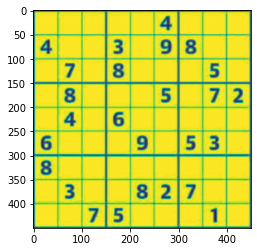

In [90]:
plt.imshow(v)

In [92]:
z = np.zeros((81,))

In [98]:
z.reshape((9,9))

array([[1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 8., 1., 9., 0., 1., 1.],
       [1., 4., 1., 0., 1., 1., 1., 5., 1.],
       [1., 0., 1., 1., 1., 5., 1., 4., 0.],
       [1., 0., 1., 6., 1., 1., 1., 1., 1.],
       [6., 1., 1., 1., 9., 1., 5., 0., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 8., 1., 1., 0., 0., 4., 1., 1.],
       [1., 1., 4., 0., 1., 1., 1., 0., 1.]])

In [96]:
z = np.zeros((81,))
for i in range(len(boxes)):
    z[i]=int(getprediction(boxes[i],new_model))

In [ ]:
import matplotlib.pyplot as plt

fig, ax =plt.subplots(1,1)
data=[[1,2,3],
      [5,6,7],
      [8,9,10]]
column_labels=["Column 1", "Column 2", "Column 3"]
ax.axis('tight')
ax.axis('off')
ax.table(cellText=data,colLabels=column_labels,loc="center")

plt.show()

TypeError: object of type 'numpy.float64' has no len()

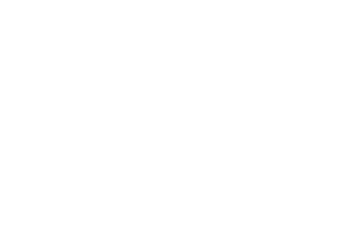

In [102]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots(1,1)
column_labels=[]
ax.axis('tight')
ax.axis('off')
ax.table(cellText=z,loc="center")

plt.show()

In [33]:
# load and prepare the image
def load_image(bx):
    # load the image
    #img = load_img(filename, grayscale=True, target_size=(28, 28))
    # convert to array
    img = img_to_array(bx)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [30]:
# getting the model 
def getprediction(boxes,new_model):
    


SyntaxError: unexpected EOF while parsing (<ipython-input-30-207914f838d9>, line 3)

In [54]:
# finding digits
imgSolvedDigits = imgblank.copy()
boxes = splitboxes(imgWarpCol)
new_model = tf.keras.models.load_model('final_model.h5')
numbers = getprediction(boxes, new_model)


error: OpenCV(4.5.2) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [34]:
bx = cv2.resize(boxes[5],(28,28))
bx1 = load_image(bx)


In [22]:
cv2.imshow("Sample",bx)
cv2.waitKey(0)

-1

In [20]:
cv2.imshow("Sample",boxes[5])
cv2.waitKey(0)

-1

In [17]:
imgStack = stackImages(0.5,([boxes[i],boxes[i+1],boxes[i+2],boxes[i+3]],[boxes[i+4],boxes[i+5],boxes[i+6],boxes[i+7]]))
# showing the output 
cv2.imshow("Final Stack", imgStack)
cv2.waitKey(0)

-1

In [16]:
new_model = tf.keras.models.load_model('final_model.h5')


In [87]:
pts2 = np.float32([[0,0],[wdt,0],[0,hgt],[wdt,hgt]])

In [92]:
mat

array([[ 3.35436067e+00,  1.76774254e-16, -2.95183739e+02],
       [ 0.00000000e+00,  1.82737559e+00, -1.29743667e+02],
       [-3.79358446e-19, -1.00130169e-04,  1.00000000e+00]])

In [41]:
final_otpt = 
biggest.reshape((4,2))[1]

array([ 88, 205], dtype=int32)

In [78]:
val = np.array([biggest.reshape((4,2))[np.argmin(biggest.reshape((4,2)).sum(1))],
biggest.reshape((4,2))[np.argmin(np.diff(biggest.reshape((4,2)),1))],
biggest.reshape((4,2))[np.argmax(np.diff(biggest.reshape((4,2)),1))],
biggest.reshape((4,2))[np.argmax(biggest.reshape((4,2)).sum(1))]]).reshape((4,1,2))

In [71]:
biggest

array([[[ 88,  71]],

       [[ 88, 205]],

       [[161, 205]],

       [[162,  71]]], dtype=int32)

In [79]:
val

array([[[ 88,  71]],

       [[162,  71]],

       [[ 88, 205]],

       [[161, 205]]], dtype=int32)

In [58]:
np.diff(biggest.reshape((4,2)),1)

array([[-17],
       [117],
       [ 44],
       [-91]], dtype=int32)

In [51]:
biggest[1,0,:]

array([ 88, 205], dtype=int32)

In [53]:
biggest

TypeError: 'list' object cannot be interpreted as an integer